<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/PinSage/PinSage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import random
from collections import deque

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings

warnings.filterwarnings(action='ignore')

In [2]:
class Config:
    data_path = '/content/drive/MyDrive/RecsysTutorial/Data/MovieLens' # 데이터 경로
    model_path = '/content/drive/MyDrive/RecsysTutorial/Model/'
    model_name = 'PinSage'
    
    hidden_dim = 64
    neighborhood_nums = [5, 5]
    K = 2

    lr = 0.001
    epochs = 30
    batch_size = 128
    num_workers = 4
    seed = 22

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    total_items = None
    input_dim = None

config = Config()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 데이터 로드

In [4]:
ratings = pd.read_csv(os.path.join(config.data_path, 'ratings.csv'))
ratings = ratings.sort_values(['userId', 'timestamp']).reset_index(drop = True)
ratings['userId'] = ratings['userId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

movies = pd.read_csv(os.path.join(config.data_path, 'movies.csv'))
movies['movieId'] = movies['movieId'].astype(str)

# 데이터 전처리

In [5]:
def get_column_to_idx_and_idx_to_column(df : pd.DataFrame, column : str):
    column_to_idx = {}
    idx_to_column = {}

    item_list = df[column].unique()

    for idx, item in enumerate(item_list):
        column_to_idx[item] = idx
        idx_to_column[idx] = item
    
    return column_to_idx, idx_to_column

userId_to_idx, idx_to_userId = get_column_to_idx_and_idx_to_column(df=ratings, column='userId')
movieId_to_idx, idx_to_movieId = get_column_to_idx_and_idx_to_column(df=movies, column='movieId')

ratings['pre_userId'] = ratings['userId'].apply(lambda x : userId_to_idx[x])
ratings['pre_movieId'] = ratings['movieId'].apply(lambda x : movieId_to_idx[x])

movies['pre_movieId'] = movies['movieId'].apply(lambda x : movieId_to_idx[x])
movies = movies.sort_values('pre_movieId').reset_index(drop = True)

config.total_items = movies['pre_movieId'].tolist()

In [6]:
# feature 생성

movies['genres_list'] = movies['genres'].apply(lambda  x : x.split('|'))

total_genres = []

genres_list = movies['genres_list'].tolist()
for genres in genres_list:
    total_genres += genres

total_genres = list(set(total_genres))

genre_to_idx = {}

for idx, genre in enumerate(total_genres):
    genre_to_idx[genre] = idx

movies['pre_genres_list'] = movies['genres_list'].apply(lambda  x : [genre_to_idx[i] for i in x])

feature = np.zeros((len(movies), len(total_genres)))
for movie in movies.iloc:
    feature[movie['pre_movieId'], movie['pre_genres_list']] = 1

feature = torch.tensor(feature, dtype = torch.float32)
config.input_dim = len(total_genres)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df : pd.DataFrame, total_items : list, K : int, neighborhood_nums : list, train : bool = True):

        self.movie_to_user = self.get_A_to_B(df = ratings, A = 'pre_movieId', B = 'pre_userId')
        self.user_to_movie = self.get_A_to_B(df = ratings, A = 'pre_userId', B = 'pre_movieId')
        self.target_nodes = sorted(df['pre_movieId'].unique().tolist())

        self.total_items = total_items
        self.K = K
        self.neighborhood_nums = neighborhood_nums
        self.train = train

    def get_A_to_B(self, df : pd.DataFrame, A : str, B : str):
        A_to_B = {}
        A_group_df = df.groupby(A)
        for A_id, A_g_d in A_group_df:
            A_to_B[A_id] = A_g_d[B].tolist()
    
        return A_to_B

    def get_subgraph(self, K : int, neighborhood_nums : list, target_node : int, node_to_edge : dict, edge_to_node : dict):
        num_nodes = 1
        for i in range(K):
            if i == 0: num_nodes += neighborhood_nums[i]
            else: num_nodes += neighborhood_nums[i - 1] * neighborhood_nums[i]
        
        # Random_Walk
        edges = []
        nodes = [target_node]
        node_to_node = []

        q = deque([[target_node, 1]])

        while q:
            now_node, depth = q.popleft()
            if depth > K:
                continue
            for _ in range(neighborhood_nums[depth - 1]):

                edge = random.choice(node_to_edge[now_node])
                next_node = random.choice(edge_to_node[edge])

                while next_node in nodes:
                    edge = random.choice(node_to_edge[now_node])
                    next_node = random.choice(edge_to_node[edge])
                
                edges.append(edge)
                nodes.append(next_node)
                node_to_node.append((now_node, next_node))

                q.append([next_node, depth + 1])

        # subgraph 생성 -> adj
        node_to_idx = {node : idx for idx, node in enumerate(nodes)}
        adj = np.zeros((num_nodes, num_nodes))

        for now_node, next_node in node_to_node:
            adj[node_to_idx[now_node], node_to_idx[next_node]] = 1
            adj[node_to_idx[next_node], node_to_idx[now_node]] = 1

        return nodes, node_to_idx[target_node], adj, edges, num_nodes

    def __len__(self):
        return len(self.target_nodes)
    
    def __getitem__(self, idx):
        target_node = self.target_nodes[idx]
        
        nodes, target_node, adj, users, num_nodes = self.get_subgraph(K = self.K, neighborhood_nums=self.neighborhood_nums, target_node=target_node, node_to_edge=self.movie_to_user, edge_to_node=self.user_to_movie)

        if self.train:

            pos_items = []
            for user in users:
                pos_items += self.user_to_movie[user]
            
            query_nodes, _, _, _, _ = self.get_subgraph(K = self.K, neighborhood_nums=self.neighborhood_nums, target_node=random.choice(pos_items), node_to_edge=self.movie_to_user, edge_to_node=self.user_to_movie)

            neg_items = list(set(self.total_items) - set(pos_items))

            if len(neg_items) < num_nodes - 1:
                neg_nodes = [target_node] + np.random.choice(neg_items, num_nodes - 1, replace = True).tolist()
            else:
                neg_nodes = [target_node] + np.random.choice(neg_items, num_nodes - 1, replace = False).tolist()
            
            return {"train":self.train, "target_node":target_node, "adj":adj, "pos_nodes":nodes, "neg_nodes":neg_nodes, "query_nodes": query_nodes}
        
        return {"train":self.train, "nodes":nodes, "target_node":target_node, "adj":adj}

In [8]:
def make_collate_fn(samples):
    train = samples[0]['train']
    if train:
        pos_nodes = []
        neg_nodes = []
        query_nodes = []
        target_nodes = []
        adj = []

        for sample in samples:
            pos_nodes += [sample['pos_nodes']]
            neg_nodes += [sample['neg_nodes']]
            query_nodes += [sample['query_nodes']]
            target_nodes += [sample['target_node']]
            adj += [sample['adj']]

        return {
            'pos_nodes' : torch.tensor(pos_nodes, dtype = torch.long), 
            'neg_nodes': torch.tensor(neg_nodes, dtype = torch.long),
            'query_nodes': torch.tensor(query_nodes, dtype = torch.long),
            'target_nodes': target_nodes,
            'adj': torch.tensor(adj, dtype = torch.float32),
            }

    else:
        nodes = []
        target_nodes = []
        adj = []

        for sample in samples:
            nodes += [sample['nodes']]
            target_nodes += [sample['target_node']]
            adj += [sample['adj']]

        return {
            'nodes' : torch.tensor(nodes, dtype = torch.long), 
            'target_nodes': target_nodes,
            'adj': torch.tensor(adj, dtype = torch.float32),
            }

# 모델

In [9]:
class MeanPoolingAggregator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MeanPoolingAggregator, self).__init__()
        self.W = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
    
    def forward(self, adj, x):
        output = torch.bmm(adj, x) / adj.sum(dim = 2).unsqueeze(2)
        output = self.W(output)
        output = self.activation(output)
        return output

class GraphSAGELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGELayer, self).__init__()
        self.Aggregator = MeanPoolingAggregator(input_dim, hidden_dim)
        self.W = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.activation = nn.ReLU()
    
    def forward(self, adj, x):
        output = self.Aggregator(adj, x)
        output = torch.concat([x, output], dim = -1)
        output = self.W(output)
        output = self.activation(output)
        output = output / torch.linalg.norm(output, dim = 2).unsqueeze(2)
        return output

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, K):
        super(GraphSAGE, self).__init__()
        layers = []
        for _ in range(K):
            input_dim = input_dim
            layers.append(GraphSAGELayer(input_dim, hidden_dim))
            input_dim = hidden_dim
            hidden_dim = hidden_dim
        self.layers = nn.ModuleList(layers)
        self.G1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activation = nn.ReLU()
        self.G2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
    
    def forward(self, nodes, adj, feature):
        output = feature[nodes]
        for layer in self.layers:
            output = layer(adj, output)
        output = self.activation(self.G1(output))
        output = self.G2(output)
        return output

class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, K):
        super(MyModel, self).__init__()
        self.W = nn.Linear(input_dim, hidden_dim, bias=False) # sparse한 장르 vector를 dense하게 만들기 위해서 W 추가
        self.graph_sage = GraphSAGE(hidden_dim, hidden_dim, K)
    
    def forward(self, pos_nodes, neg_nodes, query_nodes, target_nodes, adj, feature, margin = 1):
        feature = self.W(feature)
        
        pos_output = self.graph_sage(pos_nodes, adj, feature)
        neg_output = self.graph_sage(neg_nodes, adj, feature)
        query_output = self.graph_sage(query_nodes, adj, feature)
        
        pos = pos_output[[i for i in range(len(target_nodes))], target_nodes, :]
        neg = neg_output[[i for i in range(len(target_nodes))], target_nodes, :]
        query = query_output[[i for i in range(len(target_nodes))], target_nodes, :]

        pos = torch.sum(query * pos, dim = 1)
        neg = torch.sum(query * neg, dim = 1)

        return (neg - pos + margin).clamp(min = 0).mean() # 0에 가까워짐
    
    def predict(self, nodes, target_nodes, adj, feature):
        feature = self.W(feature)
        output = self.graph_sage(nodes, adj, feature)
        return output[[i for i in range(len(target_nodes))], target_nodes, :]

# 학습 함수

In [10]:
def train(model, optimizer, dataloader, feature, device):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()

        loss = model(pos_nodes=data['pos_nodes'].to(device), neg_nodes=data['neg_nodes'].to(device), query_nodes=data['query_nodes'].to(device), target_nodes=data['target_nodes'], adj=data['adj'].to(device), feature=feature.to(device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    total_loss /= len(dataloader)

    return total_loss

def generate_embedding(model, dataloader, feature, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in dataloader:
            embedding = model.predict(nodes=data['nodes'].to(device), target_nodes=data['target_nodes'], adj=data['adj'].to(device), feature=feature.to(device))
            embeddings.append(embedding.cpu().numpy())
    
    return embeddings

# 학습

In [11]:
train_dataset = CustomDataset(df = ratings, total_items=config.total_items, K=config.K, neighborhood_nums=config.neighborhood_nums, train=True)
train_dataloader = DataLoader(
        train_dataset, 
        batch_size = config.batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

valid_dataset = CustomDataset(df = ratings, total_items=config.total_items, K=config.K, neighborhood_nums=config.neighborhood_nums, train=False)
valid_dataloader = DataLoader(
        valid_dataset, 
        batch_size = config.batch_size, 
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

In [12]:
seed_everything(seed=config.seed)
model = MyModel(input_dim=config.input_dim, hidden_dim=config.hidden_dim, K=config.K).to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
best_loss = 987654321

for epoch in range(1, config.epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss = train(model=model, optimizer=optimizer, dataloader=train_dataloader, feature=feature, device=config.device)
            if train_loss < best_loss:
                best_epoch = epoch
                best_loss = train_loss
                torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')
    
print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_loss:.5f}')

Epoch:   1| Train loss: 0.13641: 100%|██████████| 1/1 [00:21<00:00, 21.06s/it]
Epoch:   2| Train loss: 0.00071: 100%|██████████| 1/1 [00:21<00:00, 21.03s/it]
Epoch:   3| Train loss: 0.00057: 100%|██████████| 1/1 [00:17<00:00, 17.14s/it]
Epoch:   4| Train loss: 0.00052: 100%|██████████| 1/1 [00:15<00:00, 15.28s/it]
Epoch:   5| Train loss: 0.00060: 100%|██████████| 1/1 [00:15<00:00, 15.13s/it]
Epoch:   6| Train loss: 0.00000: 100%|██████████| 1/1 [00:15<00:00, 15.79s/it]
Epoch:   7| Train loss: 0.00020: 100%|██████████| 1/1 [00:15<00:00, 15.33s/it]
Epoch:   8| Train loss: 0.00018: 100%|██████████| 1/1 [00:15<00:00, 15.64s/it]
Epoch:   9| Train loss: 0.00046: 100%|██████████| 1/1 [00:15<00:00, 15.31s/it]
Epoch:  10| Train loss: 0.00016: 100%|██████████| 1/1 [00:15<00:00, 15.82s/it]
Epoch:  11| Train loss: 0.00082: 100%|██████████| 1/1 [00:15<00:00, 15.18s/it]
Epoch:  12| Train loss: 0.00040: 100%|██████████| 1/1 [00:15<00:00, 15.70s/it]
Epoch:  13| Train loss: 0.00015: 100%|██████████| 1/

BEST | Epoch:   6| Train loss: 0.00000


In [14]:
model.load_state_dict(torch.load(os.path.join(config.model_path, config.model_name + '.pt')))
item_embeddings = np.concatenate(generate_embedding(model=model, dataloader=valid_dataloader, feature=feature, device=config.device))

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(item_embeddings)

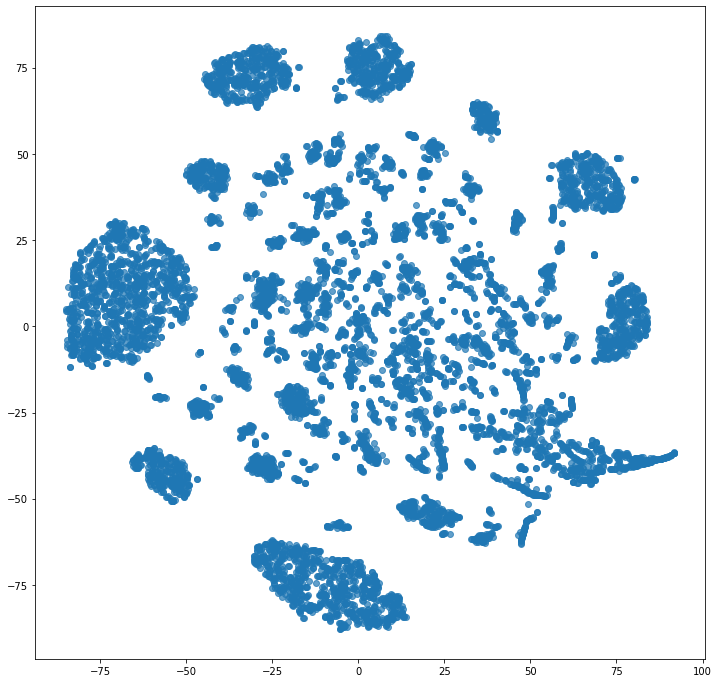

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(x = tsne_vectors[:, 0], y = tsne_vectors[:, 1], alpha = 0.7) 
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

target_nodes = valid_dataloader.dataset.target_nodes

node_to_idx = {}
idx_to_node = {}

for idx, target_node in enumerate(target_nodes):
    node_to_idx[target_node] = idx
    idx_to_node[idx] = target_node

sim_vector = cosine_similarity(item_embeddings[[node_to_idx[movieId_to_idx['1']]]], item_embeddings)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_movieId[idx_to_node[rec]] for rec in rec_list]
movies.set_index('movieId').loc[rec_list, :]

,title,genres,pre_movieId,genres_list,pre_genres_list
movieId,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,7945,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,3217,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,6705,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,3003,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,2506,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
114552,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy,8676,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"
6536,Sinbad: Legend of the Seven Seas (2003),Adventure|Animation|Children|Fantasy,4690,"[Adventure, Animation, Children, Fantasy]","[6, 1, 17, 15]"
65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,7146,"[Adventure, Animation, Children, Comedy, Fantasy]","[6, 1, 17, 11, 15]"


장르 + 유저와 영화간의 연과성이 반영된 추천이 이루어지는 것으로 판단됨